# Welcome to Bellatrex

After making sure that the needed packages are installed, we can dive into the `tutorial.py` code.

## Step 1: import libraries and set parameters

Import the required libraries and set the parameters for the grid search, data folder paths, and other configuration variables

In [1]:
import os
# set a small value for MAX_SAMPLES_EXPLAIN for quick code testing
MAX_SAMPLES_EXPLAIN = 2 # default amount is len(X_test), which is capped at 100

p_grid = {
    "n_trees": [80, 100],
    "n_dims": [2, None],
    "n_clusters": [1, 2, 3]
    }

##########################################################################
root_folder = os.getcwd()

data_folder = os.path.join(root_folder, "example-data")

''' choose appropriate learning task wth SETUP parameter '''
# for this tutorial you cna choose between "bin", "surv", or "mtr" 
SETUP = "bin"

VERBOSE = 4
PLOT_GUI = True

'''  levels of verbosity in this script:
    - >= 1.0: print best params, their achieved fidelity,
              and the scoring method used to compute such performance
    - >= 2.0: print final tree idx cluster sizes
              and generate txt files with the extracted rule-paths (if FILE_OUT is not 'None' or 'False')
    - >= 3.0: plot vector representation of the extracted trees (two plots: cluster memberships and prediction / loss])
    - >= 4.0: plot trees with GUI (if PLOT_GUI == True)
    - >= 4.0: plot trees without GUI (if PLOT_GUI == False)
    - >= 5.0: print params and performance during GridSearch
'''

# running different RFs or different performance measures according to the 
# prediction scenarios. So far we have implemented the following 5 cases:
binary_key_list = ["bin", "binary"]
survival_key_list = ["surv", "survival"]
multi_label_key_list = ["multi", "multi-l", "multi-label", "mtc"]
regression_key_list = ["regression", "regress", "regr"]
mt_regression_key_list = ["multi-target", "multi-t", "mtr"]


names_map = { # associate to each example scenario the name of the dataset
    'bin': 'blood',
    'surv': 'whas500',
    'mtr': 'scpf'
}

## Step 2: Load and preprocess Data

Load training and testing data from the `.csv` files, split them into features (X) and targets (y), and preprocess the data by formatting the target variables according to the prediction scenarios. Instantiate the appropriate `RandomForest` model.

In [2]:
import numpy as np
import pandas as pd
from code_scripts.utilities import output_X_y

df_train = pd.read_csv(os.path.join(data_folder, SETUP + '_tutorial_train.csv'))
df_test = pd.read_csv(os.path.join(data_folder, SETUP + '_tutorial_test.csv'))

X_train, y_train = output_X_y(df_train, SETUP)
X_test, y_test = output_X_y(df_test, SETUP)


orig_n_labels = y_test.shape[1] # meaningful only in multi-output set-ups

from code_scripts.utilities import format_targets

from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

y_train, y_test = format_targets(y_train, y_test, SETUP, VERBOSE)

### instantiate original R(S)F estimator, with moderate pruning (we do not want pure leaves)
if SETUP.lower() in survival_key_list:
    clf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                              random_state=0)

elif SETUP.lower() in binary_key_list + multi_label_key_list:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=5,
                                random_state=0)
    
elif SETUP.lower() in regression_key_list + mt_regression_key_list:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=5,
                               random_state=0)

clf.fit(X_train, y_train)


RandomForestClassifier(min_samples_split=5, random_state=0)

## Step 3: Instantiate and fit the Model

Once the Random Forest is instantiated, the `fit` method in Bellatrex trains the Random Forest and set the parameters for Bellatrex.


In [3]:
from code_scripts.LocalMethod_class import Bellatrex

# fit RF here. The hyperparameters are given      
Bellatrex_fitted = Bellatrex(clf, SETUP,
                            p_grid=p_grid,
                            proj_method="PCA",
                            dissim_method="rules",
                            feature_represent="weighted",
                            n_jobs=1,
                            verbose=VERBOSE,
                            colormap= 'RdYlBu_r',
                            plot_GUI=PLOT_GUI).fit(X_train, y_train)


Model is already fitted, building explanation.
oracle_sample is: None


Now we store train data predictions. This is useful for plotting the output distribution and compare it to the test data predictions.

In this example we store the .npy array as: data_name + '_tutorial_y_train_preds.npy'
You might want to change it according to the dataset and fold under consideration

In [4]:
from code_scripts.utilities import predict_helper
y_train_pred = predict_helper(Bellatrex_fitted.clf, X_train)

data_name = str(names_map[SETUP])

npy_savefile = os.path.join(data_folder, data_name + '_y_train_preds.npy')

np.save(npy_savefile, y_train_pred)
print('prediction distribution saved in:', npy_savefile)

prediction distribution saved in: c:\Users\u0135479\Documents\GitHub\Bellatrex\example-data\blood_y_train_preds.npy



## Step 4: Make predictions, output explanations

Loop through the instances of the test set, make predictions using the Bellatrex local method, and store the results.

In [8]:
from code_scripts.utilities import score_method
# store, for every sample in the test set, the predictions from BELLATREX and the original R(S)F for comparison
N = min(X_test.shape[0], MAX_SAMPLES_EXPLAIN)        

# store final Bellatrex predictions here.
# y_pred will be a (n_samples, n_outputs_)-array for multi-output predictions , or (n_samples,)-array for single output predictions
y_pred = np.empty((0, 0))
# We harmonise the output shapes with scikit-learn's Random Forest outputs by means of the predict_helper function
from code_scripts.utilities import predict_helper, concatenate_helper
y_ens_pred = predict_helper(clf, X_test)

j = 0 # Setting fold index = 0. No cross-validation needed in this tutorial.

for i in range(N): # for every sample in the test set: call the .explain method. 
    # The hyperparameters were given in the .fit. and are actively used and tuned for every instance
    '''
    the .explain outputs:
        - the local prediction 
        - information about the Bellatrex instance: optimal parameters,
                    final extracted trees/rules, their weight in the prediction, etc... 
    '''
    FILE_OUT = None
    # uncomment the next 3 lines to store the explanations as .txt files :
    FILENAME_OUT = "Rules_"+data_name+"_f"+str(j)+'_id'+str(i)+'.txt'
    FILE_OUT = os.path.join(root_folder, 'example-explanations', FILENAME_OUT)
    print('Extracted rules stored in', FILE_OUT)

    y_local_pred, sample_info = Bellatrex_fitted.explain(X_test, i, out_file=FILE_OUT) # tuning is performed within the .explain method
    
    # We concatenate BELLATREX outputs by means of the concatenate_helper function
    y_pred = concatenate_helper(y_pred, y_local_pred, axis=0)


Extracted rules stored in c:\Users\u0135479\Documents\GitHub\Bellatrex\example-explanations\Rules_blood_f0_id0.txt
best params: {'n_clusters': 3, 'n_dims': 2, 'n_trees': 100}
Achieved fidelity: 0.9253
(Tuned according to L2)
final trees indices: [35, 47, 74]
final cluster sizes: [43 30 27]


## Step 4 (extra): Enhanced explanations

Plotting explanation for instance 0


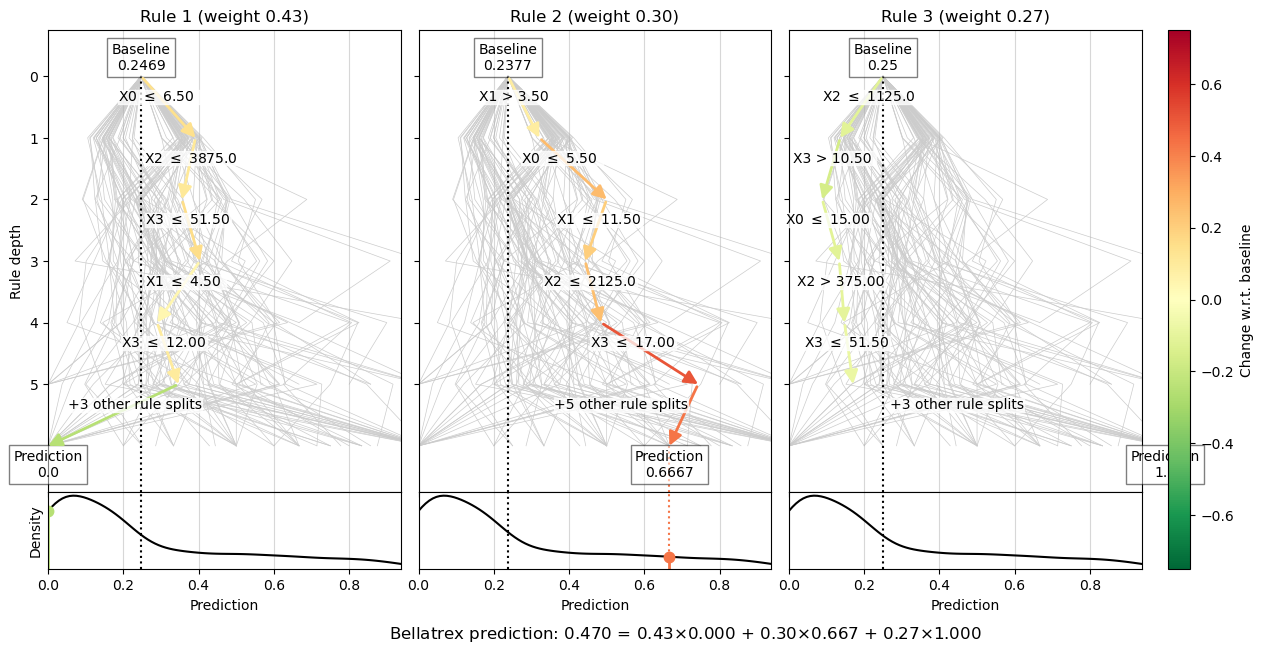

##############################
Plotting explanation for instance 1


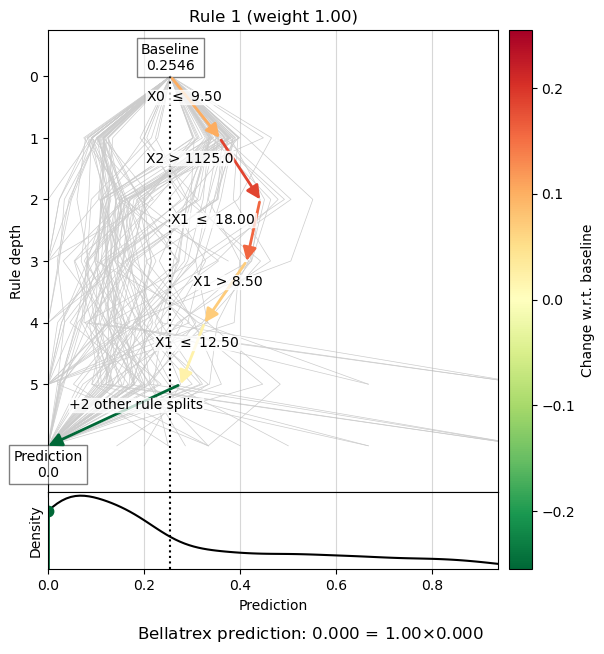

##############################


In [8]:
from visualisation import read_rules, plot_rules
import matplotlib.pyplot as plt

for i in range(N):

    print("Plotting explanation for instance", i, flush=True)

    rules, preds, baselines, weights, other_preds = read_rules(
        file       = f"example-explanations/Rules_{data_name}_f0_id{i}.txt",
        file_extra = f"example-explanations/Rules_{data_name}_f0_id{i}-extra.txt"
    )
    preds_distr = np.load(f"example-data/{data_name}_y_train_preds.npy")
    axs = plot_rules(rules, preds, baselines, weights, 
                max_rulelen=6, other_preds=other_preds, preds_distr=preds_distr,
    )
    # axs[0,0].set_xlim([0, 1]) # manually set x-axis for density plot
    plt.show()
    print('#'*30)
    # plt.savefig("visualisation.pdf")
